In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

2024-05-25 19:47:12.359349: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load the digits dataset
digits = load_digits()

# Extract features (X) and labels (y) from the dataset
X = digits['data']
y = digits['target']

# Print the shape of X and y to verify their dimensions
print(f'X.shape: {X.shape}')
print(f'y.shape: {y.shape}')

X.shape: (1797, 64)
y.shape: (1797,)


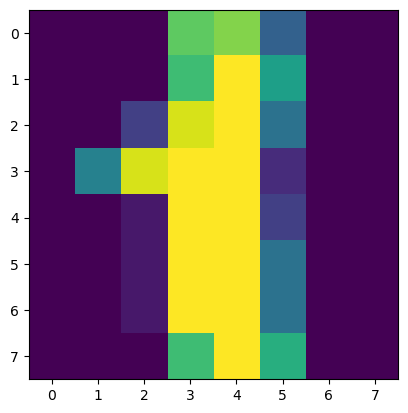

In [3]:
# Visualize a sample image from the dataset
plt.imshow(X[1].reshape(8, 8))

In [4]:
# Scale the features to the range [0, 1]
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [5]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [6]:
# Transpose the data to match the expected input shape for our model
X_train = X_train.T
X_test = X_test.T
y_train = tf.keras.utils.to_categorical(y_train).T

# Print the shapes of training and testing data to verify their dimensions
print(f'X_train.shape: {X_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'y_test.shape: {y_test.shape}')

X_train.shape: (64, 1203)
X_test.shape: (64, 594)
y_train.shape: (10, 1203)
y_test.shape: (594,)


In [7]:
def initialize_parameters(layer_dims):
    """
    Initialize parameters for the neural network with multiple layers.
    
    Arguments:
    layer_dims -- list containing the number of units in each layer
    
    Returns:
    params -- dictionary containing initialized parameters
    """
    params = {}
    for i in range(1, len(layer_dims)):
        params[f'W{i}'] = tf.Variable(tf.random.normal(shape=(layer_dims[i], layer_dims[i-1])) * tf.sqrt(2/layer_dims[i-1]))
        params[f'b{i}'] = tf.Variable(tf.zeros(shape=(layer_dims[i], 1)))
    
    return params

In [8]:
def forward_propagation(X, params):
    """
    Perform forward propagation to predict the output.
    
    Arguments:
    X -- input data of shape (n_x, m)
    params -- dictionary containing initialized parameters
    
    Returns:
    y_hat -- predicted output
    """
    l = len(params) // 2
    A = X
    for i in range(1, l):
        Z = params[f'W{i}'] @ A + params[f'b{i}']
        A = tf.nn.relu(Z)
    
    Z = params[f'W{l}'] @ A + params[f'b{l}']
    y_hat = tf.nn.softmax(Z)
    
    return y_hat

In [9]:
def compute_cost(y, y_hat):
    """
    Compute the cost using categorical cross-entropy.
    
    Arguments:
    y -- true labels
    y_hat -- predicted probabilities
    
    Returns:
    cost -- categorical cross-entropy cost
    """
    loss = tf.keras.losses.categorical_crossentropy(y, y_hat)
    return tf.reduce_mean(loss)

In [10]:
def gradient_descent(params, grads, learning_rate):
    """
    Update parameters using gradient descent.
    
    Arguments:
    params -- dictionary containing parameters
    grads -- dictionary containing gradients of the cost with respect to parameters
    learning_rate -- learning rate for gradient descent
    
    Returns:
    params -- updated parameters
    """
    for i in params.keys():
        params[i].assign_sub(learning_rate * grads[i])
    
    return params

In [11]:
def learning_rate_decay(learning_rate, epoch_num, decay_rate=1, time_interval=1000):
    """
    Decay the learning rate over time.
    
    Arguments:
    learning_rate -- initial learning rate
    epoch_num -- current epoch number
    decay_rate -- rate of decay
    time_interval -- time interval for decay
    
    Returns:
    updated_learning_rate -- decayed learning rate
    """
    updated_learning_rate = learning_rate / (1 + decay_rate * epoch_num / time_interval)
    return updated_learning_rate

In [12]:
def nn_model(X, y, layer_dims, epochs, learning_rate, decay_rate=1, print_cost=False):
    """
    Train the neural network model.
    
    Arguments:
    X -- input data
    y -- true labels
    layer_dims -- list containing the number of units in each layer
    epochs -- number of epochs to train the model
    learning_rate -- initial learning rate
    decay_rate -- rate of decay for learning rate
    print_cost -- whether to print the cost during training
    
    Returns:
    params -- trained parameters
    """
    params = initialize_parameters(layer_dims)
    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            y_hat = forward_propagation(X, params)
            cost = compute_cost(y, y_hat)
            
            if print_cost and epoch % 100 == 0:
                print(f'Epoch:{epoch}, Cost: {cost:0.2f}')
        
        grads = tape.gradient(cost, params)
        decayed_learning_rate = learning_rate_decay(learning_rate, epoch, decay_rate)
        params = gradient_descent(params, grads, decayed_learning_rate)
    
    return params

In [13]:
# Set hyperparameters
LEARNING_RATE = 0.025
EPOCHS = 1000
LAYER_DIMS = [X_train.shape[0], 64, 32, y_train.shape[0]]  # Number of units in each layer

# Train the model and get the final parameters
params = nn_model(X_train, y_train, LAYER_DIMS, EPOCHS, LEARNING_RATE, decay_rate=2, print_cost=True)

2024-05-25 19:47:16.716309: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch:0, Cost: 852.57
Epoch:100, Cost: 594.17
Epoch:200, Cost: 582.57
Epoch:300, Cost: 579.22
Epoch:400, Cost: 577.88
Epoch:500, Cost: 577.47
Epoch:600, Cost: 577.19
Epoch:700, Cost: 577.00
Epoch:800, Cost: 576.89
Epoch:900, Cost: 576.83


In [14]:
def predict(X, params):
    """
    Make predictions using the trained model.
    
    Arguments:
    X -- input data
    params -- trained parameters
    
    Returns:
    predictions -- array of predictions
    """
    y_hat = forward_propagation(X, params)
    predictions = np.argmax(y_hat, axis=0)
    
    return predictions

In [15]:
# Make predictions using the trained model
y_pred = predict(X_test, params)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        55
           1       0.98      1.00      0.99        55
           2       1.00      1.00      1.00        52
           3       0.98      0.98      0.98        56
           4       1.00      1.00      1.00        64
           5       0.99      0.97      0.98        73
           6       0.98      1.00      0.99        57
           7       0.98      0.98      0.98        62
           8       1.00      0.98      0.99        52
           9       0.99      0.99      0.99        68

    accuracy                           0.99       594
   macro avg       0.99      0.99      0.99       594
weighted avg       0.99      0.99      0.99       594



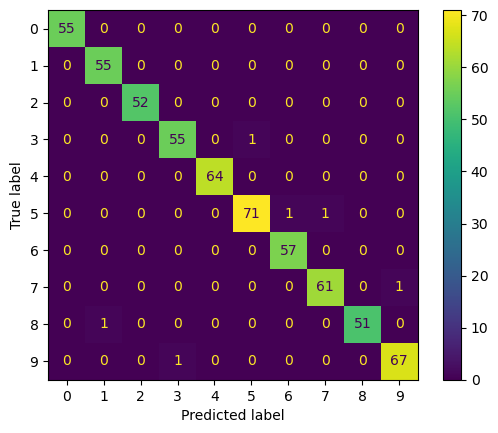

In [16]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Evaluate the model using classification report and confusion matrix
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

In [17]:
# Make predictions using the trained model
y_pred_train = predict(X_train, params)

# Calculate and print the accuracy score on the training set
accuracy_train = np.mean(y_pred_train == y_train.argmax(axis=0))
print(f'Training Accuracy: {accuracy_train}')

Training Accuracy: 1.0


In [18]:
# Calculate and print the accuracy score on the test set
accuracy_test = np.mean(y_pred == y_test)
print(f'Test Accuracy: {accuracy_test}')

Test Accuracy: 0.98989898989899


In [19]:
def find_closest_factors(number):
    """
    Find the closest factors of a number.
    
    Arguments:
    number -- input number
    
    Returns:
    a -- one factor
    b -- another factor
    """
    a = int(np.sqrt(number))
    for i in range(a, 0, -1):
        if number % i == 0:
            return i, number // i

In [20]:
# Calculate the number of misclassifications
errors = np.sum(y_test != y_pred)

# Find and print the closest factors of the number of misclassifications
a, b = find_closest_factors(errors)
print(f'Number of Misclassifications: {errors} = {a} * {b}')

Number of Misclassifications: 6 = 2 * 3


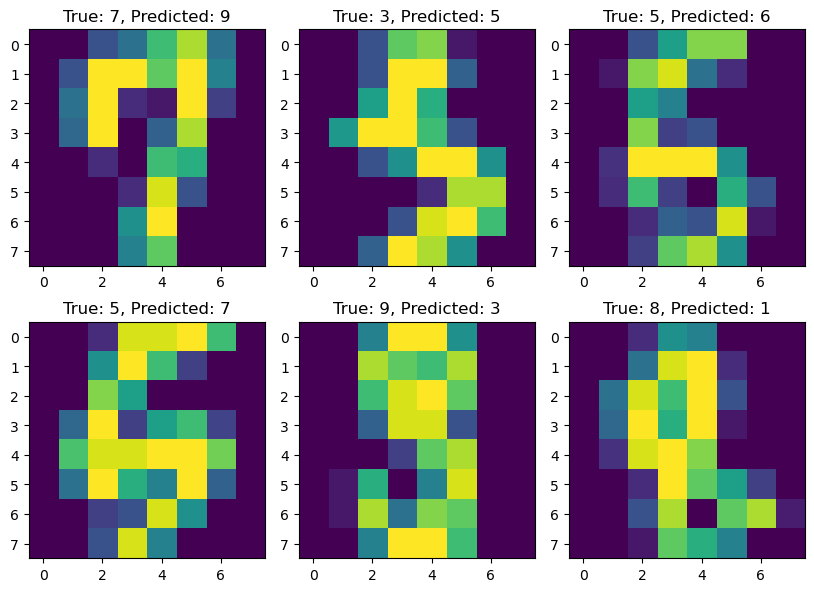

In [21]:
# Visualize some of the misclassified digits
# Plot a grid of images of misclassified digits along with their true and predicted labels
misclassified_indices = np.where(y_test != y_pred)[0]
num_misclassified = len(misclassified_indices)

# Create subplots for each misclassified digit
fig, axs = plt.subplots(a, b, figsize=(b*2.75, a*3))
for i, ax in enumerate(axs.flat):
    ax.imshow(X_test[:, misclassified_indices[i]].reshape(8, 8))
    ax.set_title(f'True: {y_test[misclassified_indices[i]]}, Predicted: {y_pred[misclassified_indices[i]]}')

# Show the plot
plt.tight_layout()
plt.show()